In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
from os.path import isfile, join
import math

import tensorflow.keras as keras
from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten, LeakyReLU, Dense
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from datetime import date

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array


# training data
image_size = 224
#labels = pd.read_csv("data/fgvc7/train.csv")
image_dir = "data/leaf"

In [168]:
# import image data and combine labels
def load_unlabeled_data(image_dir, extension = '.JPG'):
    X = []
    for root, folder, files in os.walk(image_dir):
        #print(files)
        for f in files:
            #print(f)
            if f.endswith(extension):
                #print(root, folder, f)
                img = load_img(f'{root}/{f}', target_size=(image_size,image_size,3))
                img_array = img_to_array(img, dtype='uint8')
                X.append(img_array)
    return np.array(X, dtype=np.uint8)

In [169]:
# import training data and combine labels
data = load_unlabeled_data(image_dir) 

In [170]:
import imgaug.augmenters as iaa
seq = iaa.Sequential([
    iaa.OneOf([
        iaa.AverageBlur(k=((3, 5), (5, 7))),
        iaa.Rotate((-45,45)),
        iaa.Affine(scale=(0.5, 0.95)),    
        iaa.Multiply((0.50, 1.1))
        #,iaa.BlendAlphaRegularGrid(nb_rows=(4, 6), nb_cols=(1, 4),
        #                        foreground=iaa.Multiply(0.0))
        #,iaa.Cartoon()
        ,iaa.Cutout(nb_iterations=(1, 3), size=0.2, squared=False, cval=0)
        ,iaa.Affine(shear=(-48, 48))
        ,iaa.Affine(translate_px={"x": (-42, 42), "y": (-36, 36)})
        ,iaa.KeepSizeByResize(iaa.Resize({"height": (0.70, 0.90), "width": (0.70, 0.90)}))
        ,iaa.CropAndPad(percent=(-0.2, 0.2))
        #,iaa.PiecewiseAffine(scale=(0.01, 0.05))
        ,iaa.PerspectiveTransform(scale=(0.01, 0.1))
        #,iaa.WithPolarWarping(iaa.CropAndPad(percent=(-0.1, 0.1)))
        #,iaa.ElasticTransformation(alpha=(0, 3.0), sigma=0.5)
       ])
    #,iaa.SaveDebugImageEveryNBatches(folder_path, 100)    
], random_order=True)

In [171]:
def generator(features, batch_size):
    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
      
        # Transform X1 and X2
        x_aug_1 = seq(images =features[indexes])
        x_aug_2 = seq(images =features[indexes])
        yield np.array(x_aug_1), np.array(x_aug_2)

In [172]:
images = generator(data, 9)
image = next(images)

(-0.5, 2015.5, 447.5, -0.5)

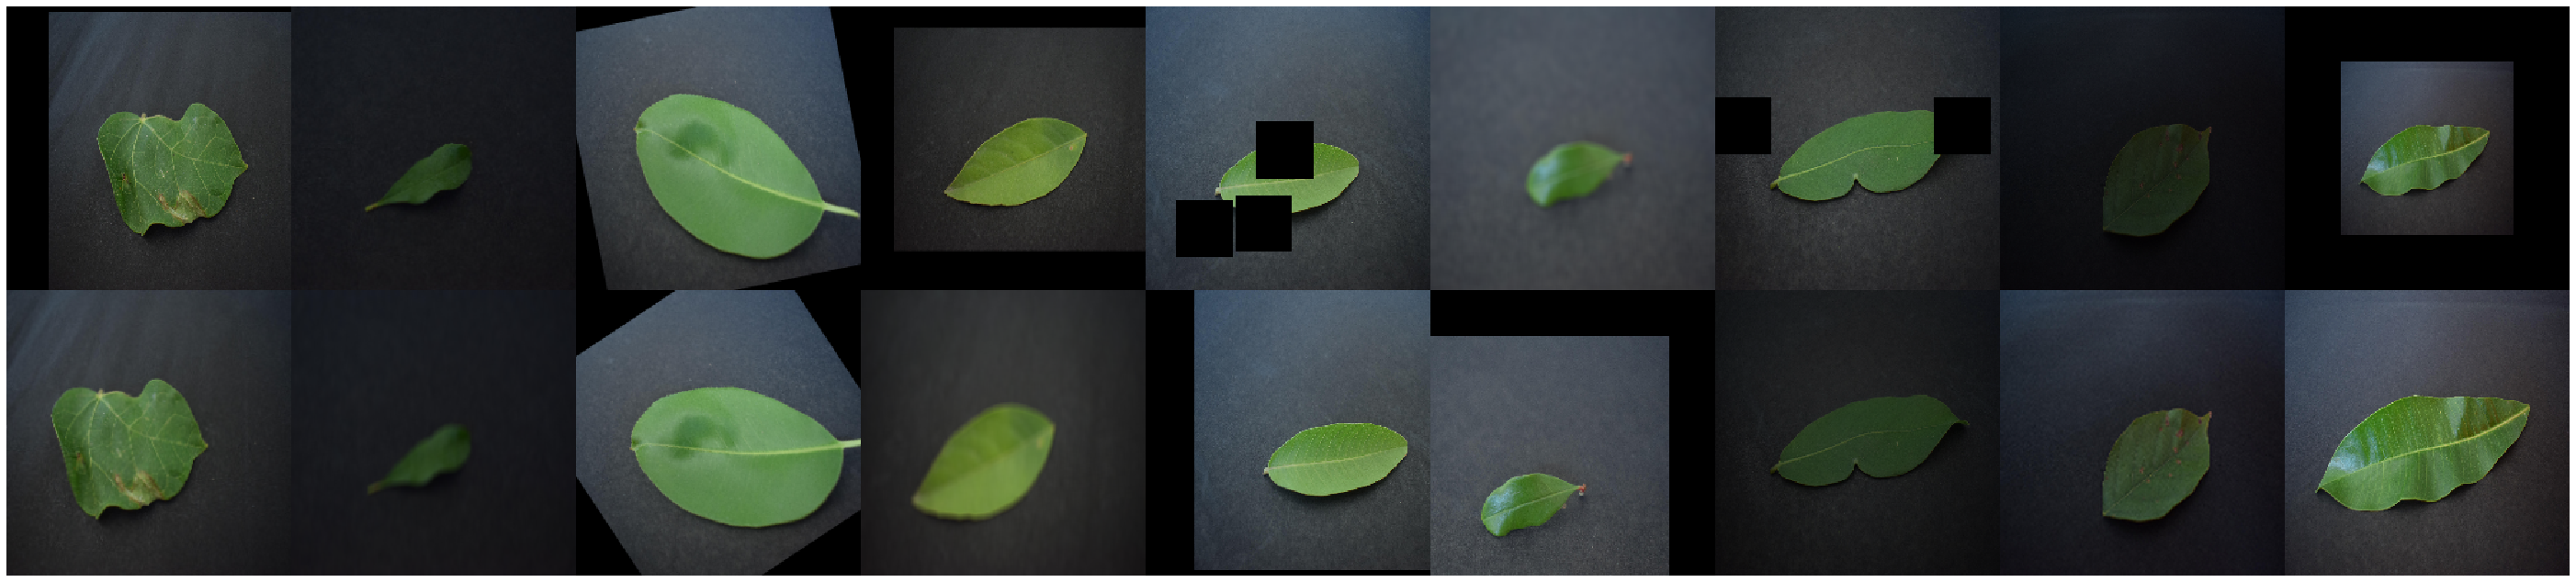

In [173]:
img_mat = np.zeros((2*image_size, 9*image_size,3),dtype='int32')
image = np.array(image)
for i in range(2):
    for j in range(9):
        img_mat[i*image_size:(i+1)*image_size, j*image_size:(j+1)*image_size,:] = image[i,j,:,:,:]
plt.figure(figsize=(50, 50))
plt.imshow(img_mat)
plt.axis("off")

In [51]:
from tensorflow.keras import applications
base_model = applications.EfficientNetB0(weights='imagenet', input_shape=(image_size, image_size, 3),  include_top=False)

# Create new model on top.
inputs = keras.Input(shape=(image_size, image_size, 3))
x = base_model(inputs, training=True)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1024)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1311744   
Total params: 5,361,315
Trainable params: 5,319,292
Non-trainable params: 42,023
_________________________________________________________________


In [59]:
# Get all layers for efficientnet
e = model.get_layer('efficientnetb0')
for l in e.layers:
    print(l.name)

input_9
rescaling_3
normalization_3
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
block3a_se_expand
block3a_se_

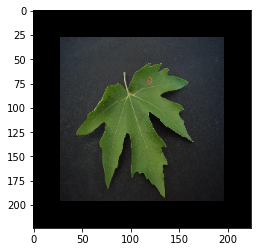

In [81]:
np.random.shuffle(data)
images = generator(data, 1)

learning_rate = LinearWarmUpCosineDecay(total_iterations, config.learning_rate)

for image in data:
    image1, image2 = next(images)
    loss, grads = train_step(model, config, image1[0], image2[0])
    epoch_loss.append(loss)

    optimizer.__setattr__('lr', learning_rate(optimizer.iterations))
    optimizer.apply_gradients(zip(grads, model.trainable_variables))     

In [121]:
def add_to_summary(summary_writer, loss, learning_rate, image1, image2, iteration):
    """Adds loss, learning_rate and images to tensorflow summary"""

    with summary_writer.as_default():
        tf.summary.scalar('Loss', loss, iteration)
        tf.summary.scalar('Learning_rate', learning_rate, iteration)
        tf.summary.image('image1', image1, iteration)
        tf.summary.image('image2', image2, iteration)
        
        
def nt_xent(z1, z2, batch_size, temperature, zdim):
    """Implements normalized temperature-scaled cross-entropy loss
    Args:
        z1: normalized latent representation of first set of augmented images [N, D]
        z2: normalized latent representation of second set of augmented images [N, D]
        batch_size: number of images in batch
        temperature: temperature for softmax. set in config
        zdim: dimension for latent representation set in config
    Returns:
        loss: contrastive loss averaged over batch (2*N samples)
    """

    # reshape so that the order is z1_1,z2_1,z1_2,z2_2,z1_3,z2_3
    z = tf.concat([z1,z2], axis=0)
    z_ = tf.reshape(tf.transpose(tf.reshape(z, [2, batch_size, zdim]), [1,0,2]), [batch_size*2, -1])

    # compute cosine similarity
    # a has order [z1_1*batch_size*2, z1_2*batch_size*2, ...]
    # b has order [z1_1, z1_2, z3_1 ...]
    a = tf.reshape(tf.transpose(tf.tile(tf.reshape(z_, [1, batch_size*2, zdim]), [batch_size*2 ,1, 1]), [1, 0, 2]), [batch_size*2*batch_size*2, zdim])
    b = tf.tile(z_, [batch_size*2, 1])
    sim = cosine_similarity(a, b)
    sim = tf.expand_dims(sim, axis=1)/temperature
    sim = tf.reshape(sim, [batch_size*2, batch_size*2])
    sim = tf.math.exp(sim-tf.reduce_max(sim))

    pos_indices = tf.concat([tf.range(1, (2*batch_size)**2, (batch_size*4)+2), tf.range(batch_size*2, (2*batch_size)**2, (batch_size*4)+2)], axis=0)
    pos_indices = tf.expand_dims(pos_indices, axis=1)
    pos_mask = tf.zeros(((2*batch_size)**2, 1), dtype=tf.int32)
    pos_mask = tf.tensor_scatter_nd_add(pos_mask, pos_indices, tf.ones((batch_size*2, 1), dtype=tf.int32))
    pos_mask = tf.reshape(pos_mask, [batch_size*2, batch_size*2])
    neg_mask = tf.ones((batch_size*2, batch_size*2), dtype=tf.int32) - tf.eye(batch_size*2, dtype=tf.int32)

    # similarity between z11-z12, z12-z11, z21-22, z22-z21 etc. 
    pos_sim = tf.reduce_sum(sim*tf.cast(pos_mask, tf.float32), axis=1) 

    # negative similarity consists of all similarities except i=j
    neg_sim = tf.reduce_sum(sim*tf.cast(neg_mask, tf.float32), axis=1)
    loss = -tf.reduce_mean(tf.math.log(tf.clip_by_value(pos_sim/neg_sim, 1e-10, 1.0)))

    return loss

def cosine_similarity(a, b):
    """Computes the cosine similarity between vectors a and b"""

    numerator = tf.reduce_sum(tf.multiply(a, b), axis=1)
    denominator = tf.multiply(tf.norm(a, axis=1), tf.norm(b, axis=1))
    cos_similarity = numerator/denominator
    return cos_similarity

In [179]:
epoch_loss = [] 
batch_size = 32
temperature = 0.1
z_dim = model.output.shape[1]
# try 4502
total_iterations = math.ceil(len(data) / batch_size)
lr = 0.001
total_epoch = 10

from tensorflow.keras.experimental import CosineDecay
lr_decayed_fn = tf.keras.experimental.CosineDecay( lr, total_iterations)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

checkpoint = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, "models\checkpoints", max_to_keep=10)

summary_writer = tf.summary.create_file_writer("models\summary")

images = generator(data, batch_size)
for e in range(total_epoch):
    checkpoint = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=model)
    print(f"********************************************************************")
    print(f"**                               Epoch: {e}                         **")
    print(f"********************************************************************")
    for i in range(total_iterations):
        image1, image2 = next(images)
        # Train one step
        with tf.GradientTape() as tape:
            z1 = model(image1, training=True)
            z2 = model(image2, training=True)
            z1 = tf.math.l2_normalize(z1, axis=1)
            z2 = tf.math.l2_normalize(z2, axis=1)
            loss = nt_xent(z1, z2, batch_size,  temperature, zdim )
            reg_loss = tf.add_n(model.losses) if model.losses else 0
            loss = loss + reg_loss
        gradients = tape.gradient(loss, model.trainable_variables)

        # record loss
        epoch_loss.append(loss)

        # update optimizer
        optimizer.__setattr__('lr', lr_decayed_fn(i+1))

        # apply gradients
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))        

        # 
        checkpoint.step.assign_add(1)
        if checkpoint.step.numpy() % 10 == 0:
            print(f"Iter: {i+2} Step: {checkpoint.step.numpy()} Loss: {loss.numpy():.5f} LR: {optimizer.__getattribute__('lr').numpy():9f}")
            add_to_summary(summary_writer, loss, optimizer.__getattribute__('lr'), image1[:1], image2[:1], checkpoint.step.numpy())
            summary_writer.flush()
    save_path = manager.save()
    print(f"Saved checkpoint for Epoch {e}: {save_path}")
    print("loss {:1.2f}".format(loss.numpy()))

******************************************************************
**                               Epoch: 0                       **
******************************************************************
Iter: 10 Step: 10 Loss: 0.31698352098464966 LR: 0.000989980879239738
Iter: 20 Step: 20 Loss: 0.2999632954597473 LR: 0.0009558619931340218
Iter: 30 Step: 30 Loss: 0.2779695987701416 LR: 0.0008992060320451856
Iter: 40 Step: 40 Loss: 0.35056251287460327 LR: 0.0008228138904087245
Iter: 50 Step: 50 Loss: 0.24802608788013458 LR: 0.0007304624887183309
Iter: 60 Step: 60 Loss: 0.2996184229850769 LR: 0.0006267173448577523
Iter: 70 Step: 70 Loss: 0.2937290668487549 LR: 0.0005167074268683791
Iter: 80 Step: 80 Loss: 0.4449269771575928 LR: 0.0004058716876897961
Iter: 90 Step: 90 Loss: 0.14549711346626282 LR: 0.00029968933085910976
Iter: 100 Step: 100 Loss: 0.24041324853897095 LR: 0.0002034101344179362
Iter: 110 Step: 110 Loss: 0.20184467732906342 LR: 0.00012179375335108489
Iter: 120 Step: 120 Loss: 0.2

KeyboardInterrupt: 

In [200]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1311744   
Total params: 5,361,315
Trainable params: 5,319,292
Non-trainable params: 42,023
_________________________________________________________________


In [219]:
x2 = keras.layers.GlobalAveragePooling2D()(model.layers[-3].output)
outputs2 = keras.layers.Dense(4)(x2)
model2 = keras.Model(model.layers[1].input, outputs2)
model2.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_3 (Rescaling)         (None, 224, 224, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
normalization_3 (Normalization) (None, 224, 224, 3)  7           rescaling_3[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_3[0][0]            
___________________________________________________________________________________________

In [223]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras import applications
from tensorflow.keras.layers import Flatten, LeakyReLU, Dense
from tensorflow.keras.models import *
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import random
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf


from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

from os import listdir
from os.path import isfile, join

import imgaug.augmenters as iaa

# training data
image_size = 224
labels = pd.read_csv("data/fgvc7/train.csv")
image_dir = "data/fgvc7/images"

# import image data and combine labels
def load_data(dataset='Train',image_dir= 'data/fgvc7/images'):
    X = []
    y = []
    for f in listdir(image_dir):
        if isfile(join(image_dir, f)) and f[:len(dataset)]==dataset:
            # add filename
            #train_list.append(f)
            # add image to the list
            img = load_img(f'{image_dir}/{f}', target_size=(image_size,image_size,3))
            img_array = img_to_array(img, dtype='uint8')
            # Get id
            id = int(f[len(dataset)+1:-4])
            X.append(img_array)
            if dataset=='Train':
                y.append(labels.iloc[id][['healthy', 'multiple_diseases', 'rust', 'scab']].to_numpy())
            else:
                y.append([f[:-4], id])
    if dataset=='Train':
        y = np.array(y, dtype=np.uint16)   
    return np.array(X, dtype=np.uint16), y

seq = iaa.Sequential([
    iaa.SomeOf((0,2),[
        iaa.Identity(),
        iaa.AverageBlur(k=((3, 5), (5, 7))),
        iaa.Rotate((-45,45)),
        iaa.Affine(scale=(0.5, 0.95)),    
        iaa.Multiply((0.50, 1.1))
        #,iaa.BlendAlphaRegularGrid(nb_rows=(4, 6), nb_cols=(1, 4),
        #                        foreground=iaa.Multiply(0.0))
        #,iaa.Cartoon()
        ,iaa.Cutout(nb_iterations=(1, 3), size=0.2, squared=False, cval=0)
        ,iaa.Affine(shear=(-48, 48))
        ,iaa.Affine(translate_px={"x": (-42, 42), "y": (-36, 36)})
        ,iaa.KeepSizeByResize(iaa.Resize({"height": (0.70, 0.90), "width": (0.70, 0.90)}))
        ,iaa.CropAndPad(percent=(-0.2, 0.2))
        #,iaa.PiecewiseAffine(scale=(0.01, 0.05))
        ,iaa.PerspectiveTransform(scale=(0.01, 0.1))
        #,iaa.WithPolarWarping(iaa.CropAndPad(percent=(-0.1, 0.1)))
        #,iaa.ElasticTransformation(alpha=(0, 3.0), sigma=0.5)
       ])
    #,iaa.SaveDebugImageEveryNBatches(folder_path, 100)    
], random_order=True)

def generator(features, labels, batch_size):
    while True:
        # Fill arrays of batch size with augmented data taken randomly from full passed arrays
        indexes = random.sample(range(len(features)), batch_size)
      
        # Transform X and y
        x_aug = seq(images =features[indexes])
        yield np.array(x_aug), np.array(labels[indexes])
        
data_x, data_y  = load_data() 
x_train, x_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.30, random_state=42)
y_train = np.argmax(y_train,axis=1)
y_val = np.argmax(y_val,axis=1)

In [229]:
# Warm up head
adam = optimizers.Adam(learning_rate=0.0005)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                           factor=0.2,  
                           patience=3, 
                           min_lr=0.00005)
early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=6, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

batch_size = 64
#num_warmup_steps = 5

# freeze pretrained weights
for l in model2.layers[:-2]:
    l.trainable = False

model2.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy()])


history = model2.fit(generator(x_train, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=100,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )
print(model2.optimizer.lr)

Epoch 1/100
19/19 [==============================] - 53s 2s/step - loss: 5.7247 - sparse_categorical_crossentropy: 5.7247 - val_loss: 2.2762 - val_sparse_categorical_crossentropy: 2.2762
Epoch 2/100
19/19 [==============================] - 46s 2s/step - loss: 2.4341 - sparse_categorical_crossentropy: 2.4341 - val_loss: 1.7588 - val_sparse_categorical_crossentropy: 1.7588
Epoch 3/100
19/19 [==============================] - 49s 3s/step - loss: 1.8356 - sparse_categorical_crossentropy: 1.8356 - val_loss: 1.5817 - val_sparse_categorical_crossentropy: 1.5817
Epoch 4/100
19/19 [==============================] - 47s 2s/step - loss: 1.6707 - sparse_categorical_crossentropy: 1.6707 - val_loss: 1.5301 - val_sparse_categorical_crossentropy: 1.5301
Epoch 5/100
19/19 [==============================] - 48s 2s/step - loss: 1.5821 - sparse_categorical_crossentropy: 1.5821 - val_loss: 1.5309 - val_sparse_categorical_crossentropy: 1.5309
Epoch 6/100
19/19 [==============================] - 49s 3s/step 

In [230]:
# Train entire network
adam = optimizers.Adam(learning_rate=0.0001)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', 
                           factor=0.2,  
                           patience=5 , 
                           min_lr=0.00001)
early_stop = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=10, 
    verbose=0, 
    mode='auto',
    baseline=None, 
    restore_best_weights=True
)

for l in model2.layers:
    l.trainable = True
    
model2.compile(optimizer=adam, 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history2 = model2.fit(generator(x_train, y_train, batch_size),  
                    shuffle=True,  
                    validation_data = (x_val, y_val),
                    callbacks = [reduce_lr,early_stop],                        
                    epochs=200,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )

Epoch 1/200
19/19 [==============================] - 215s 10s/step - loss: 1.1164 - accuracy: 0.5572 - val_loss: 0.8055 - val_accuracy: 0.7002
Epoch 2/200
19/19 [==============================] - 206s 10s/step - loss: 0.6100 - accuracy: 0.8160 - val_loss: 0.6021 - val_accuracy: 0.7971
Epoch 3/200
19/19 [==============================] - 205s 10s/step - loss: 0.3609 - accuracy: 0.8877 - val_loss: 0.4750 - val_accuracy: 0.8519
Epoch 4/200
19/19 [==============================] - 206s 10s/step - loss: 0.2730 - accuracy: 0.9043 - val_loss: 0.3827 - val_accuracy: 0.8830
Epoch 5/200
19/19 [==============================] - 206s 10s/step - loss: 0.2278 - accuracy: 0.9366 - val_loss: 0.3146 - val_accuracy: 0.8921
Epoch 6/200
19/19 [==============================] - 205s 10s/step - loss: 0.1829 - accuracy: 0.9428 - val_loss: 0.2845 - val_accuracy: 0.9013
Epoch 7/200
19/19 [==============================] - 208s 10s/step - loss: 0.1569 - accuracy: 0.9488 - val_loss: 0.2521 - val_accuracy: 0.9104

c:\Miniconda\envs\py37_tensorflow\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


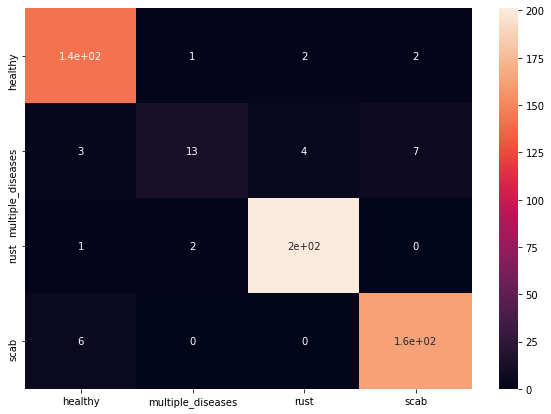

In [231]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
y_val_pred = np.argmax(model2.predict(x_val), axis=1)
mat = confusion_matrix(y_val, y_val_pred)

df_cm = pd.DataFrame(mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [232]:
# Train on all data before inference
model2.fit(generator(x_val, y_val, batch_size),            
                    epochs=2,
                    steps_per_epoch=len(x_train)/batch_size ,
                    verbose=True
                   )

Epoch 1/2
19/19 [==============================] - 192s 10s/step - loss: 0.2783 - accuracy: 0.9141
Epoch 2/2
19/19 [==============================] - 192s 10s/step - loss: 0.1693 - accuracy: 0.9383


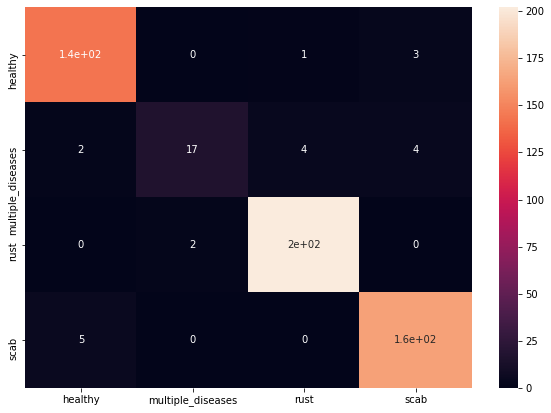

In [233]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

labels = ['healthy', 'multiple_diseases', 'rust', 'scab']
y_val_pred = np.argmax(model2.predict(x_val), axis=1)
mat = confusion_matrix(y_val, y_val_pred)

df_cm = pd.DataFrame(mat, index = [i for i in labels],
                  columns = [i for i in labels])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [235]:
# Load test data and their filename for submission file
test_x, test_id  = load_data("Test") 
test_y = model2.predict(test_x)
test_pred = tf.nn.softmax(test_y).numpy()
test_set = np.hstack((test_id, test_pred))
test_set = test_set[test_set[:,1].astype('uint16').argsort()]

test_DF = pd.DataFrame(test_set, index=test_set[:,1], columns=["image_id","id","healthy","multiple_diseases","rust","scab"])
test_DF[["image_id","healthy","multiple_diseases","rust","scab"]].to_csv('submissions/CL_20210208.csv', index=False)

image_id,healthy,multiple_diseases,rust,scab
Test_0,0.0005004153,0.0035099087,0.99563473,0.0003548315
Test_1,6.371349e-06,7.250669e-05,0.99991035,1.0772379e-05
Test_2,6.4907167e-06,3.39034e-06,4.125483e-06,0.99998605
Test_3,0.9999269,1.2985947e-05,7.137719e-06,5.2886367e-05
Test_4,0.0002945491,0.0069526616,0.9925909,0.00016185878
Test_5,0.96421415,0.010049594,0.007629813,0.018106436
Test_6,0.99994314,1.8663526e-05,3.2082007e-05,6.0673706e-06
Test_7,2.3508867e-06,0.0029362545,1.7945607e-05,0.99704343
Test_8,1.5995987e-05,0.963683,0.00076621753,0.03553478


The system cannot find the path specified.


401 - Unauthorized


The system cannot find the path specified.


In [246]:
!kaggle competitions submit -f "f:/notebooks/capstone/submissions/CL_20210208.csv" -m"CL test 20210208" plant-pathology-2020-fgvc7

Successfully submitted to Plant Pathology 2020 - FGVC7


The system cannot find the path specified.

  0%|          | 0.00/106k [00:00<?, ?B/s]
100%|##########| 106k/106k [00:00<00:00, 253kB/s]


In [247]:
 !kaggle competitions submissions plant-pathology-2020-fgvc7

fileName               date                 description                         status    publicScore  privateScore  
---------------------  -------------------  ----------------------------------  --------  -----------  ------------  
CL_20210208.csv        2021-02-09 05:43:44  CL test 20210208                    complete  0.94556      0.94149       
efficientNet2.csv      2021-02-07 07:48:56  efficientNet iter 2 20210206        complete  0.93404      0.93081       
efficientNet1.csv      2021-02-07 07:05:11  efficientNet iter 1 20210206        complete  0.93470      0.93343       
efficientNet0.csv      2021-02-07 05:55:11  efficientNet iter 0 20210206        complete  0.94182      0.93685       
efficientNet.csv       2021-02-07 05:12:58  efficientNet baseline 20210130      complete  0.93478      0.93531       
efficientNet.csv       2021-02-07 03:07:58  efficientNet baseline 20210130      complete  0.94182      0.93685       
EfficientNetB6.csv     2021-02-06 20:03:18  EfficientNet

The system cannot find the path specified.


In [249]:
model2.save('models/CL_draft_0.94149.pb')

INFO:tensorflow:Assets written to: models/CL_draft_0.94149.pb\assets


## Test Training step

In [154]:
epoch_loss = [] 
batch_size = 32
temperature = 0.1
z_dim = model.output.shape[1]

In [155]:
image1, image2 = next(images)

(-0.5, 7167.5, 447.5, -0.5)

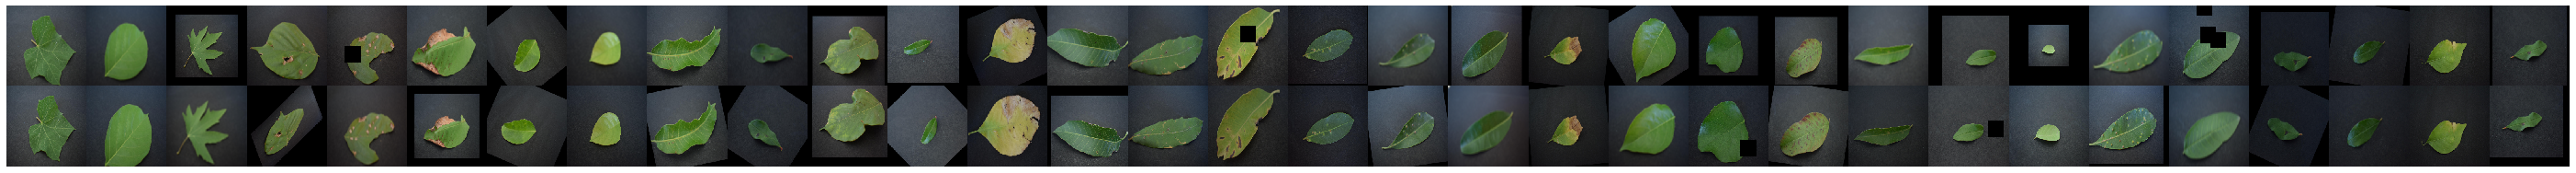

In [156]:
images = generator(data, batch_size)
img_mat = np.zeros((2*image_size, batch_size*image_size,3),dtype='int32')
image = next(images)
image = np.array(image)
for i in range(2):
    for j in range(batch_size):
        img_mat[i*image_size:(i+1)*image_size, j*image_size:(j+1)*image_size,:] = image[i,j,:,:,:]
plt.figure(figsize=(50, 50))
plt.imshow(img_mat)
plt.axis("off")

In [157]:
z1 = model(image[0], training=True)
z2 = model(image[1], training=True)
z1 = tf.math.l2_normalize(z1, axis=1)
z2 = tf.math.l2_normalize(z2, axis=1)

In [158]:
loss = nt_xent(z1, z2, batch_size,  0.1, 1024 )

In [159]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=1.8826456>

## Loss function debug

In [117]:
z1=tf.constant([[1,1],[2,2],[3,3]])
z2=tf.constant([[4,4],[5,5],[6,6]])

batch_size = 3
zdim = 2

In [119]:
z = tf.concat([z1,z2], axis=0)
print(tf.reshape(z, [2,3,2]))
print(tf.transpose(tf.reshape(z, [2,3,2])), [1,0,2])
z_= tf.reshape(tf.transpose(tf.reshape(z, [2, batch_size, zdim]), [1,0,2]), [batch_size*2, -1])
print(z_)

tf.Tensor(
[[[1 1]
  [2 2]
  [3 3]]

 [[4 4]
  [5 5]
  [6 6]]], shape=(2, 3, 2), dtype=int32)
tf.Tensor(
[[[1 4]
  [2 5]
  [3 6]]

 [[1 4]
  [2 5]
  [3 6]]], shape=(2, 3, 2), dtype=int32) [1, 0, 2]
tf.Tensor(
[[1 1]
 [4 4]
 [2 2]
 [5 5]
 [3 3]
 [6 6]], shape=(6, 2), dtype=int32)


In [120]:
a = tf.reshape(tf.transpose(tf.tile(tf.reshape(z_, [1, batch_size*2, zdim]), [batch_size*2 ,1, 1]), [1, 0, 2]), [batch_size*2*batch_size*2, zdim])
b = tf.tile(z_, [batch_size*2, 1])
print(a,b)

tf.Tensor(
[[1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [1 1]
 [4 4]
 [4 4]
 [4 4]
 [4 4]
 [4 4]
 [4 4]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [2 2]
 [5 5]
 [5 5]
 [5 5]
 [5 5]
 [5 5]
 [5 5]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [3 3]
 [6 6]
 [6 6]
 [6 6]
 [6 6]
 [6 6]
 [6 6]], shape=(36, 2), dtype=int32) tf.Tensor(
[[1 1]
 [4 4]
 [2 2]
 [5 5]
 [3 3]
 [6 6]
 [1 1]
 [4 4]
 [2 2]
 [5 5]
 [3 3]
 [6 6]
 [1 1]
 [4 4]
 [2 2]
 [5 5]
 [3 3]
 [6 6]
 [1 1]
 [4 4]
 [2 2]
 [5 5]
 [3 3]
 [6 6]
 [1 1]
 [4 4]
 [2 2]
 [5 5]
 [3 3]
 [6 6]
 [1 1]
 [4 4]
 [2 2]
 [5 5]
 [3 3]
 [6 6]], shape=(36, 2), dtype=int32)
